In [37]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from matplotlib import pyplot
import matplotlib.pyplot as plt
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils import to_categorical


In [38]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded
 
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/')
    testX, testy = load_dataset_group('test', prefix + 'HAR/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [39]:
trainX, trainy, testX, testy = load_dataset('data/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [40]:
batch_size = 32
validation_split = 0.2

In [41]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(n_timesteps,n_features), return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
train_epochs = 30
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)
   

Epoch 1/30
184/184 [==============================] - 55s 211ms/step - loss: 0.9248 - accuracy: 0.7052 - val_loss: 1.1617 - val_accuracy: 0.6506
Epoch 2/30
184/184 [==============================] - 36s 197ms/step - loss: 0.3763 - accuracy: 0.9022 - val_loss: 0.3915 - val_accuracy: 0.8960
Epoch 3/30
184/184 [==============================] - 37s 201ms/step - loss: 0.2212 - accuracy: 0.9361 - val_loss: 0.2452 - val_accuracy: 0.9232
Epoch 4/30
184/184 [==============================] - 35s 192ms/step - loss: 0.1783 - accuracy: 0.9393 - val_loss: 0.2329 - val_accuracy: 0.9273
Epoch 5/30
184/184 [==============================] - 33s 181ms/step - loss: 0.1595 - accuracy: 0.9369 - val_loss: 0.2106 - val_accuracy: 0.9327
Epoch 6/30
184/184 [==============================] - 34s 185ms/step - loss: 0.1428 - accuracy: 0.9498 - val_loss: 0.2634 - val_accuracy: 0.8872
Epoch 7/30
184/184 [==============================] - 34s 184ms/step - loss: 0.1380 - accuracy: 0.9490 - val_loss: 0.2759 - val_ac

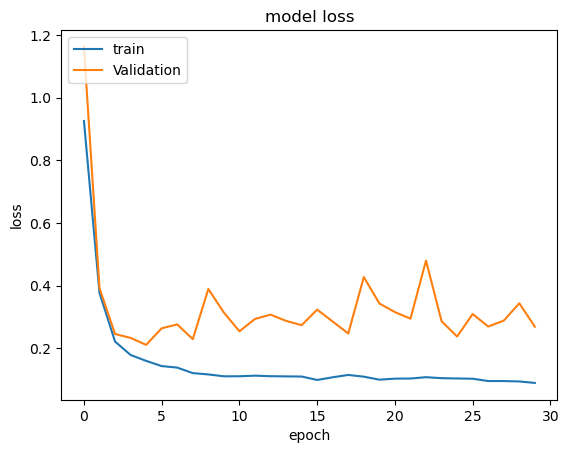

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [45]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the BiLSTM model 0.9239904880523682
93/93 [==============================] - 8s 55ms/step


In [46]:
predictions

array([[3.1791199e-06, 1.8380745e-04, 1.4174317e-05, 5.1609944e-03,
        9.9462318e-01, 1.4692253e-05],
       [2.6207160e-06, 8.3300838e-05, 7.7788882e-06, 4.5896522e-03,
        9.9530953e-01, 7.1000986e-06],
       [2.6620123e-06, 7.3674521e-05, 5.4953298e-06, 2.4018176e-02,
        9.7589773e-01, 2.2294059e-06],
       ...,
       [1.5554141e-06, 9.9998093e-01, 1.4688655e-05, 8.1368751e-07,
        1.2951467e-06, 6.7951072e-07],
       [3.2323185e-06, 9.9998498e-01, 1.0417796e-05, 5.3101348e-07,
        6.2297050e-07, 2.0854206e-07],
       [1.8994550e-06, 9.9997330e-01, 2.3039755e-05, 6.1663042e-07,
        8.4423681e-07, 3.4164816e-07]], dtype=float32)

In [47]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[466   1  29   0   0   0]
 [  7 436  27   1   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 378 107   5]
 [  0   0   0  46 486   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.99      0.94      0.96       496
      Walkup       1.00      0.93      0.96       471
    Walkdown       0.88      1.00      0.94       420
     Sitting       0.89      0.77      0.83       491
    Standing       0.82      0.91      0.86       532
      Laying       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



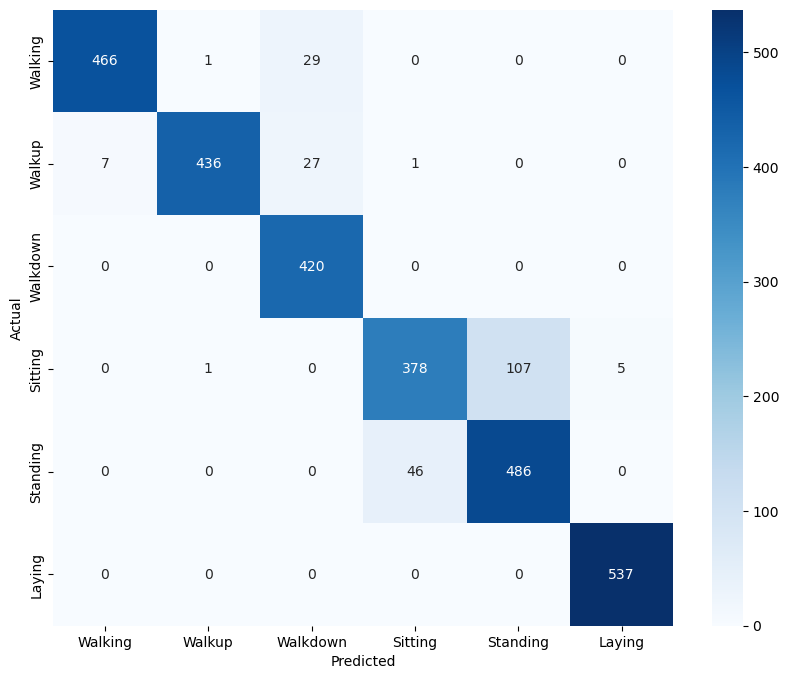

In [48]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(testy,predictions,classNames)